In [1]:
import os
import sys
import numpy as np
import cv2 
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline

os.environ['MOMAPS_HOME'] = '/home/labs/hornsteinlab/Collaboration/MOmaps'

sys.path.insert(1, os.getenv('MOMAPS_HOME'))
print(f"MOMAPS_HOME: {os.getenv('MOMAPS_HOME')}")

from cellpose import models
import cellpose
from shapely.geometry import Polygon

from src.common.lib import image_metrics
from src.common.lib.preprocessing_utils import rescale_intensity, handle_img_shape, segment
from src.common.lib.image_sampling_utils import sample_images_all_markers_all_lines, sample_raw_images, sample_processed_images
from src.common.lib.eval_preprocessing_steps_utils import get_processed_images, plot_images

MOMAPS_HOME: /home/labs/hornsteinlab/Collaboration/MOmaps
MOMAPS_HOME: /home/labs/hornsteinlab/Collaboration/MOmaps


In [2]:
%load_ext autoreload
%autoreload 2

In [72]:
INPUT_DIR_BATCH = "/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk/FUS_lines_stress_2024_sorted/batch1"
EXPECTED_SITE_WIDTH, EXPECTED_SITE_HEIGHT = 1024, 1024

sample_size = 10
rep = 'rep2'
marker = 'PSD95'
condition = 'Colchicine'
cell_line = 'FUSHeterozygous'
panel = None#'panelI'

In [73]:
images_paths = sample_raw_images(INPUT_DIR_BATCH, marker,
                                 cell_line=cell_line, condition=condition, sample_size=sample_size, rep=rep, panel=panel)
images_paths

array(['/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk/FUS_lines_stress_2024_sorted/batch1/FUSHeterozygous/panelD/Colchicine/rep2/PSD95/CCN_Panel_D1_w2confGFP_s254.tif',
       '/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk/FUS_lines_stress_2024_sorted/batch1/FUSHeterozygous/panelD/Colchicine/rep2/PSD95/CCN_Panel_D1_w2confGFP_s271.tif',
       '/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk/FUS_lines_stress_2024_sorted/batch1/FUSHeterozygous/panelD/Colchicine/rep2/PSD95/CCN_Panel_D1_w2confGFP_s263.tif',
       '/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk/FUS_lines_stress_2024_sorted/batch1/FUSHeterozygous/panelD/Colchicine/rep2/PSD95/CCN_Panel_D1_w2confGFP_s250.tif',
       '/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk/FUS_lines_stress_2024_sorted/batch1/FUSHeterozygous/panelD/Colchicine/rep2/PSD95/CCN_Panel_D1_w2confGFP_s275.tif',
       '/h

In [74]:
images = []
for p in images_paths:
    image = cv2.imread(p, cv2.IMREAD_ANYDEPTH)
    images.append(image)
    
images = np.stack(images, axis=0)
images.shape

(10, 2048, 2048)

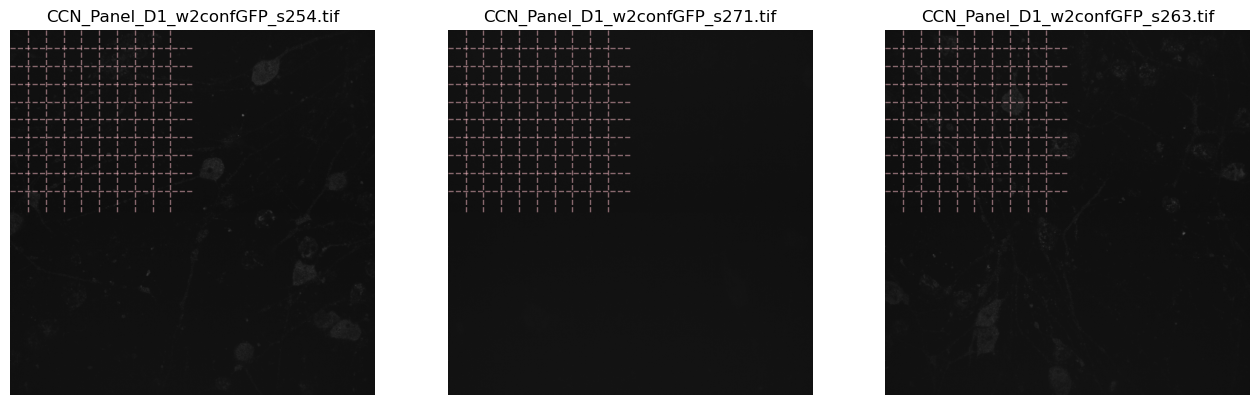

In [75]:
plot_images(images, images_paths)

In [76]:
images_processed = np.zeros((images.shape[0], EXPECTED_SITE_WIDTH, EXPECTED_SITE_HEIGHT))
images_paths_processed = images_paths.copy()

# Handle size

In [77]:
for i in range(len(images)):
    images_processed[i] = handle_img_shape(images[i], EXPECTED_SITE_WIDTH, EXPECTED_SITE_HEIGHT)

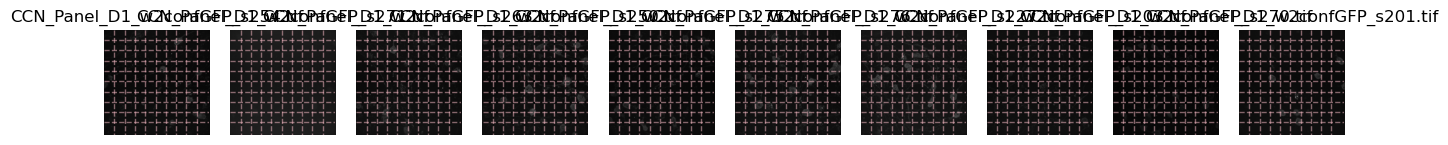

In [78]:
plot_images(images_processed, images_paths_processed, 10)

# Rescale Intensity

In [79]:
# Apply rescale intensity
for i in range(len(images_processed)):
    images_processed[i] = rescale_intensity(images_processed[i])

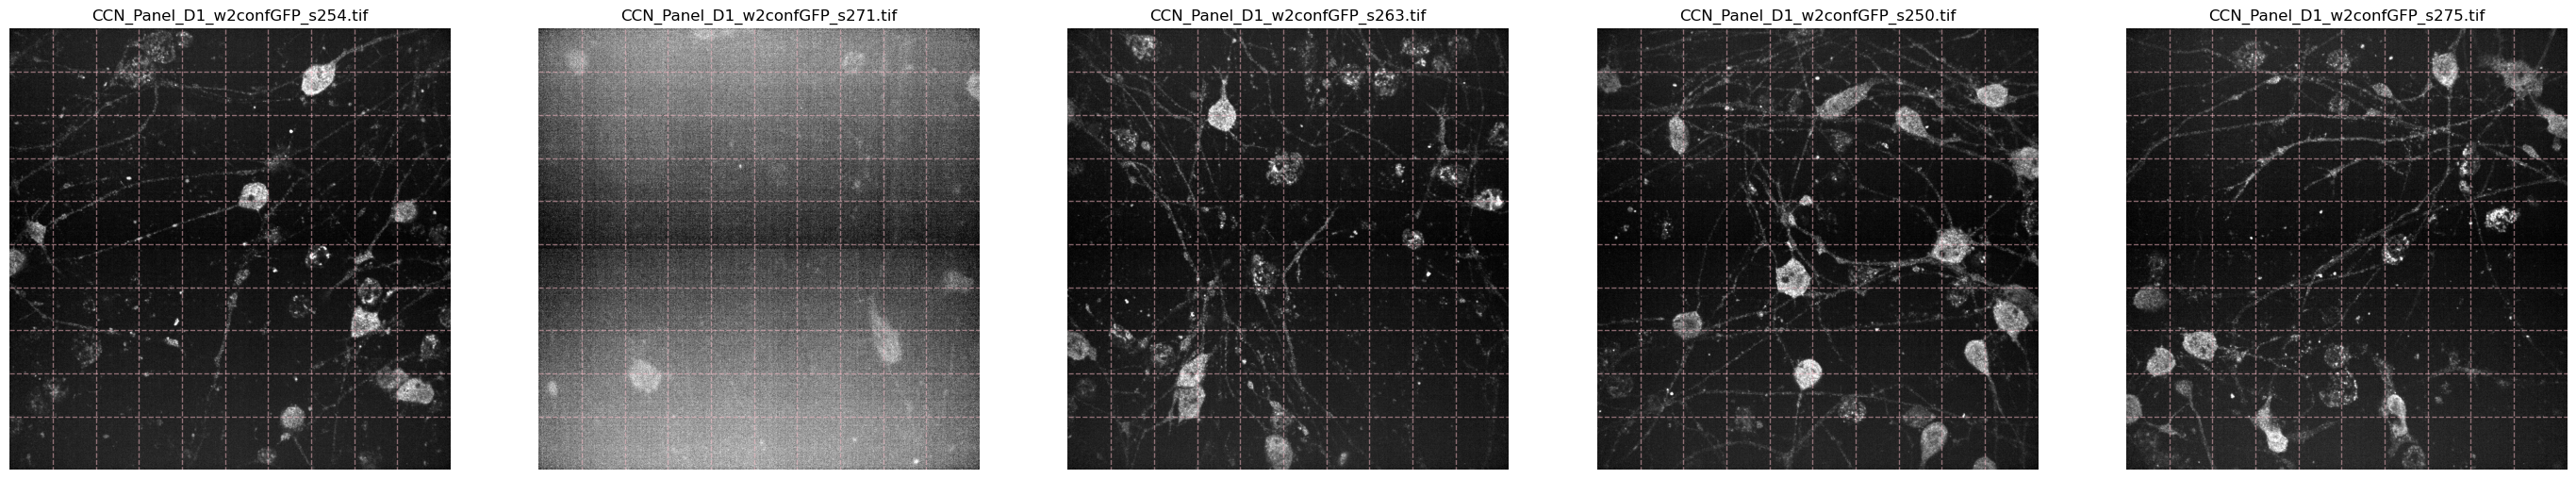

In [80]:
plot_images(images_processed, images_paths_processed, 5, figsize=(35,10))

# Brenner

In [130]:
brenner_cutoffs = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps/src/preprocessing/sites_validity_bounds_FUS.csv", index_col=0)
brenner_cutoffs

brenner_marker = brenner_cutoffs.loc[marker]
brenner_lower_bound, brenner_upper_bound = brenner_marker[0], brenner_marker[1]

No valid files (in terms of Brenner)


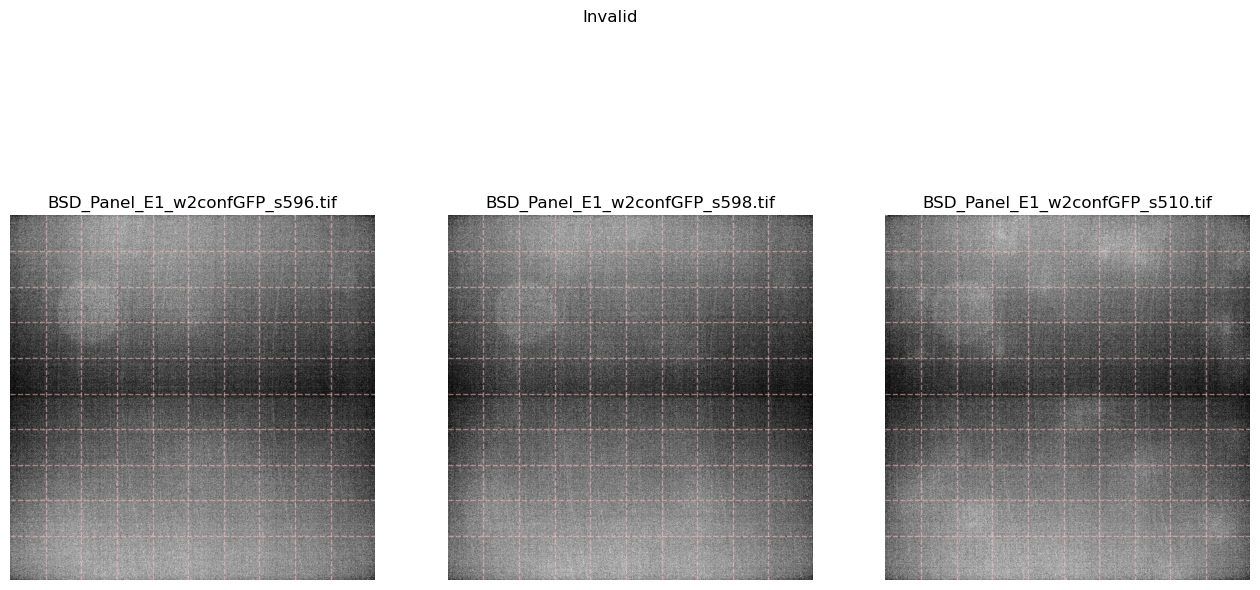

In [131]:
brenner_for_sampled_images = []

for i in range(len(images_processed)):
    brenner_for_sampled_images.append(image_metrics.calculate_image_sharpness_brenner(images_processed[i]))
brenner_for_sampled_images = np.asarray(brenner_for_sampled_images)

# Show images passed filter
passed_images_indexes = np.argwhere((brenner_for_sampled_images >= brenner_lower_bound) & (brenner_for_sampled_images <= brenner_upper_bound)).reshape(-1)
if len(passed_images_indexes) > 0:
    plot_images(images_processed[passed_images_indexes], images_paths_processed[passed_images_indexes], n_samples=min(3, len(passed_images_indexes)), suptitle='Valid')
else:
    print("No valid files (in terms of Brenner)")

# Show images failed filter
failed_images_indexes = list(set(np.arange(len(images_processed))) - set(passed_images_indexes))
if len(failed_images_indexes) > 0:
    plot_images(images_processed[failed_images_indexes], images_paths_processed[failed_images_indexes], n_samples=min(3, len(failed_images_indexes)), suptitle='Invalid')
else:
    print("All files are valid (in terms of Brenner)")

images_processed = images_processed[passed_images_indexes]
images_paths_processed = images_paths_processed[passed_images_indexes]


# Cellpose

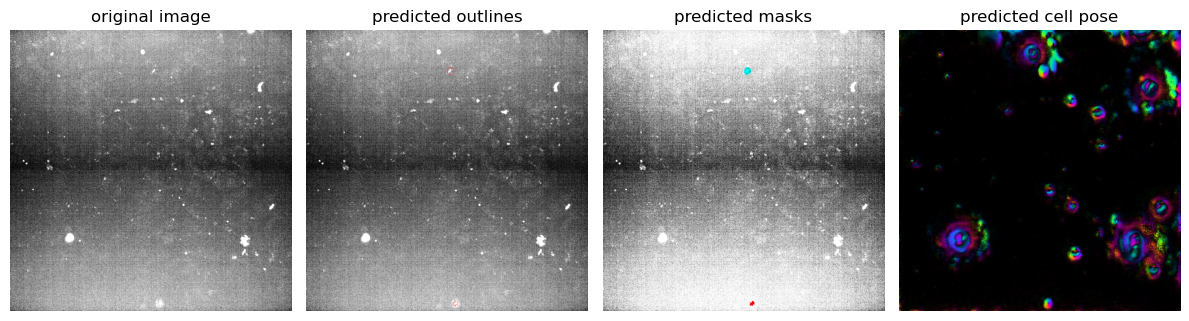

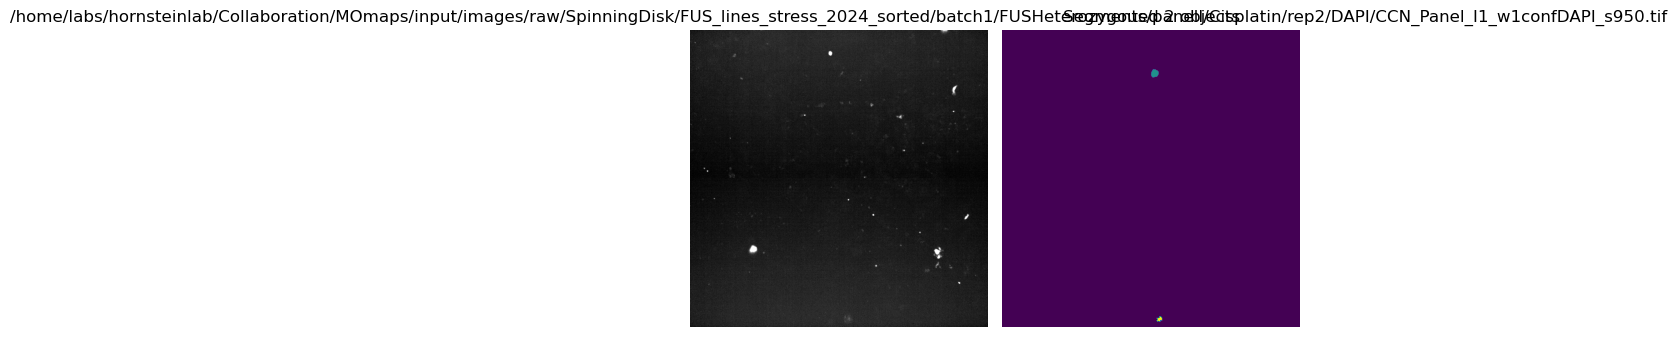

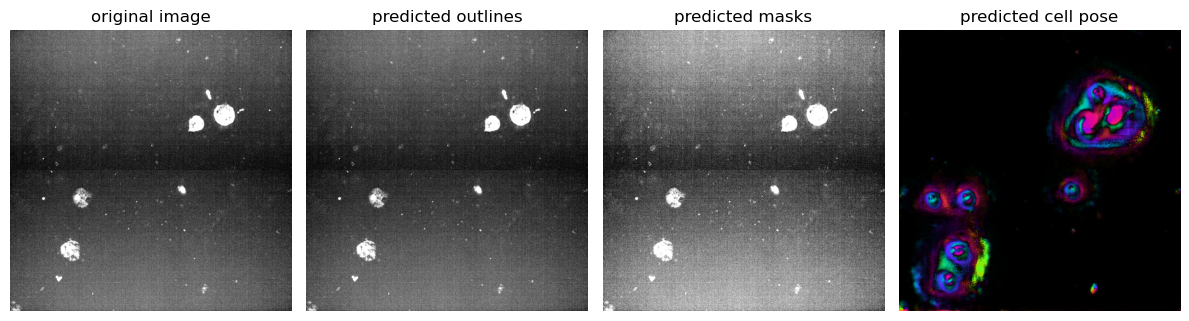

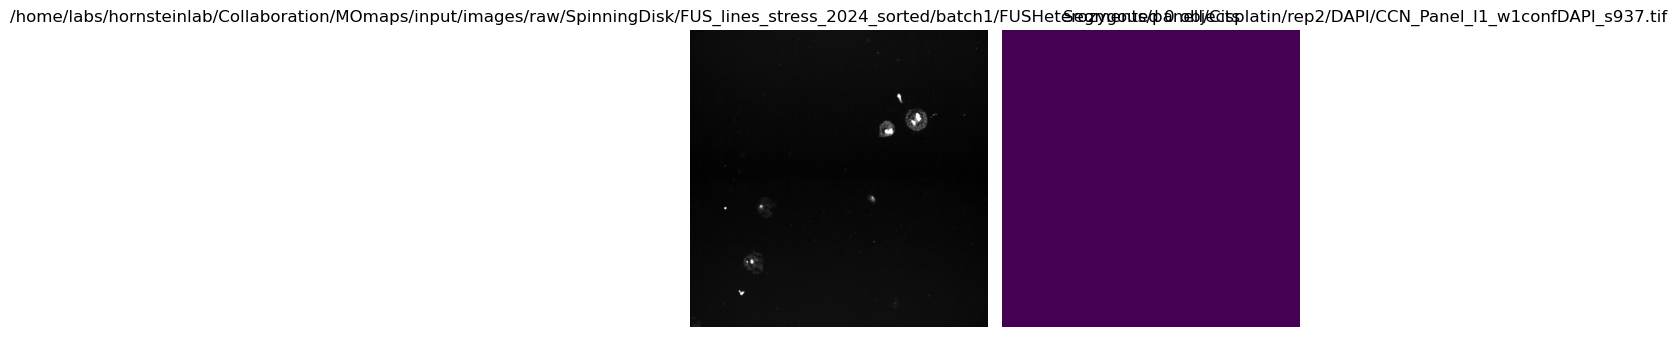

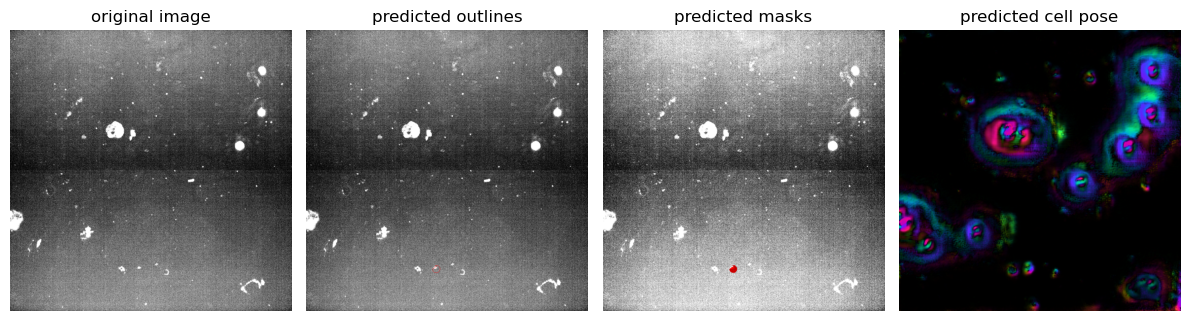

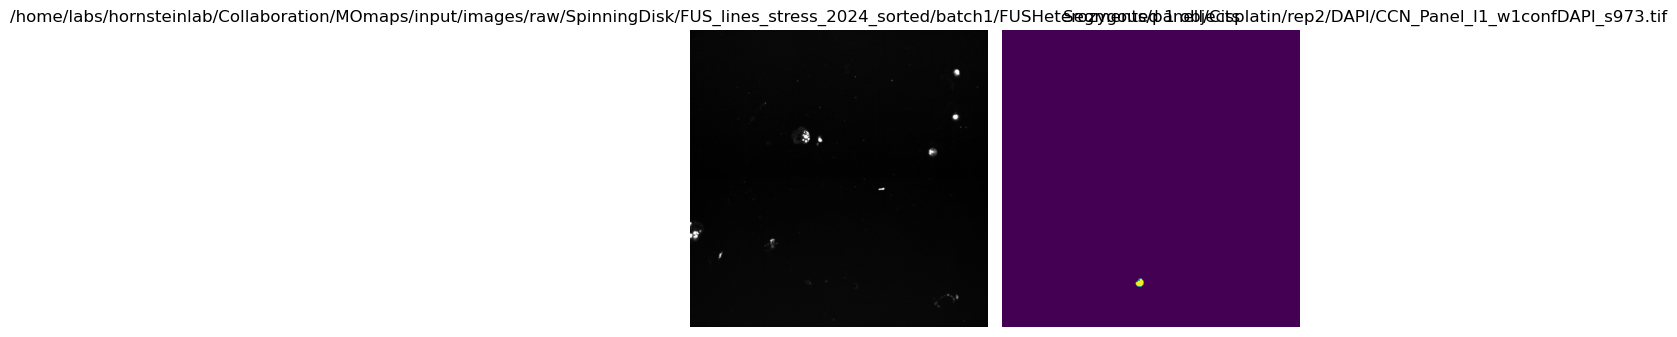

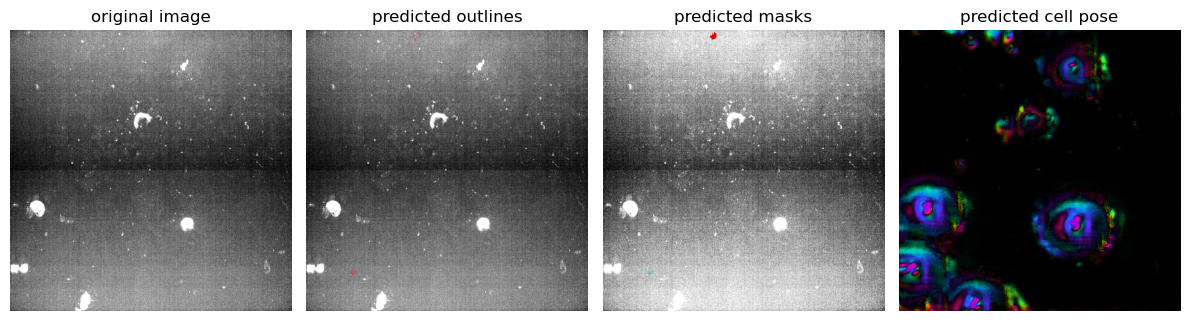

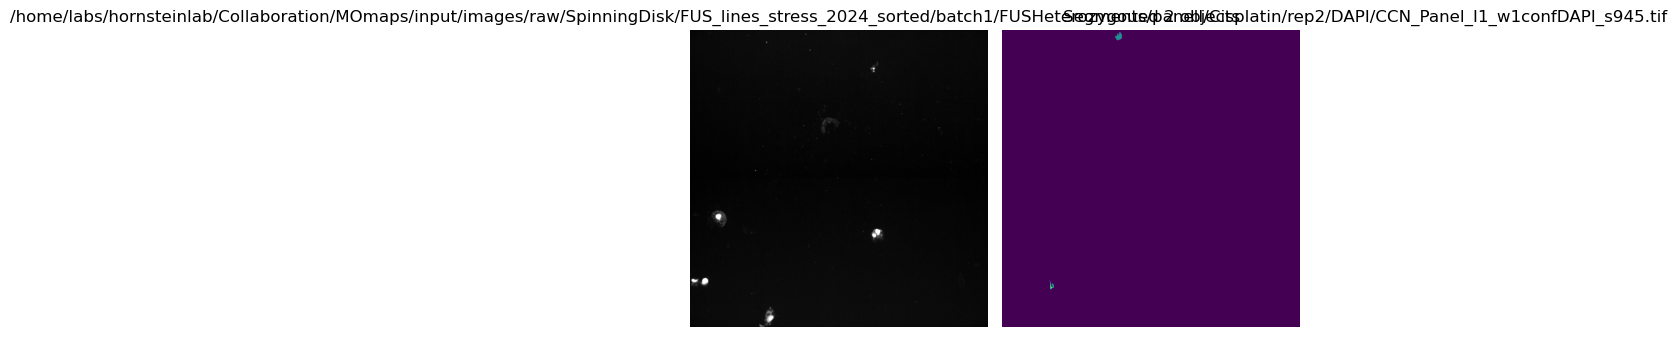

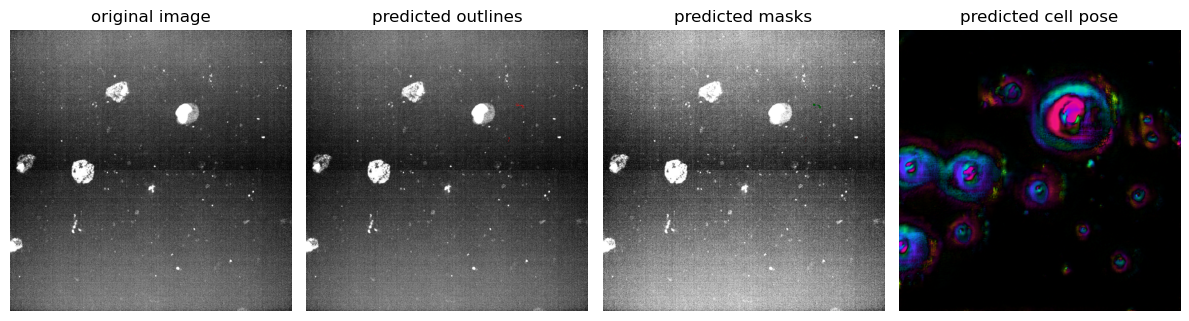

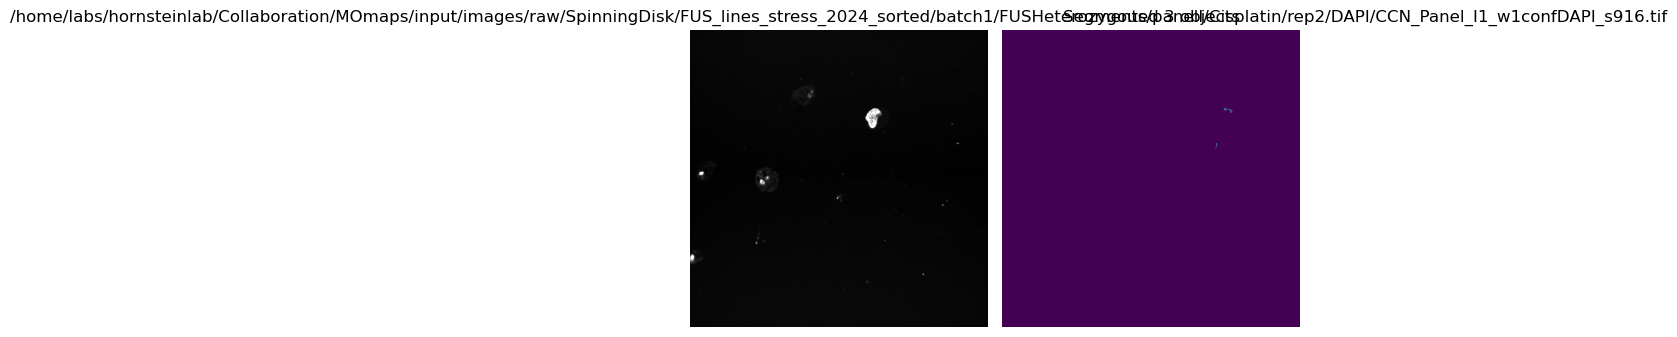

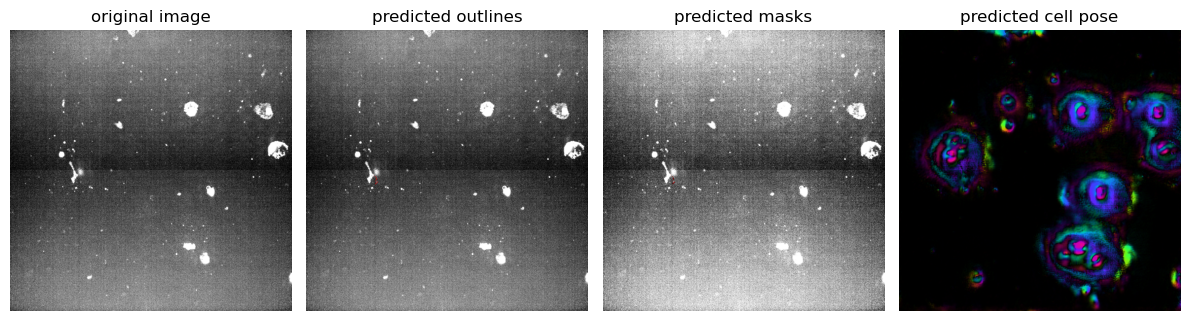

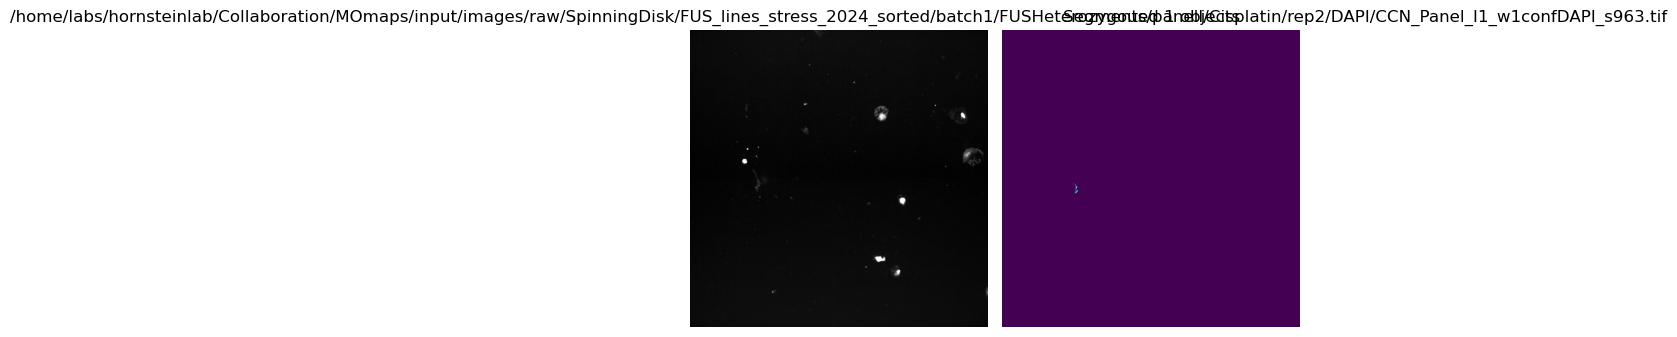

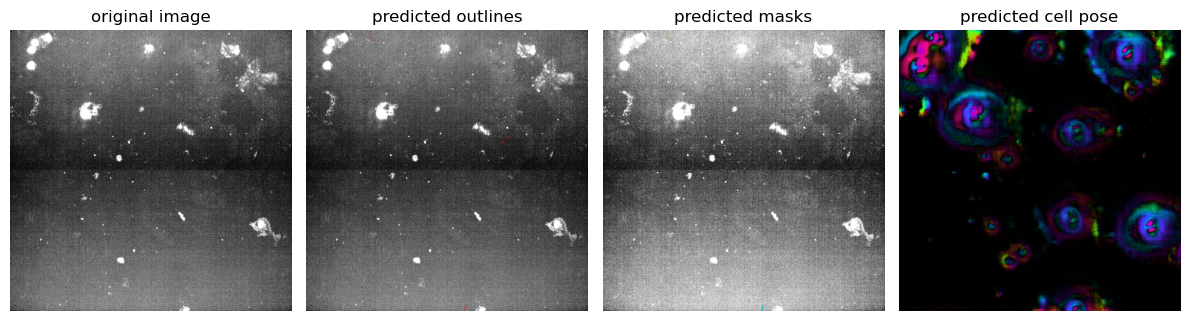

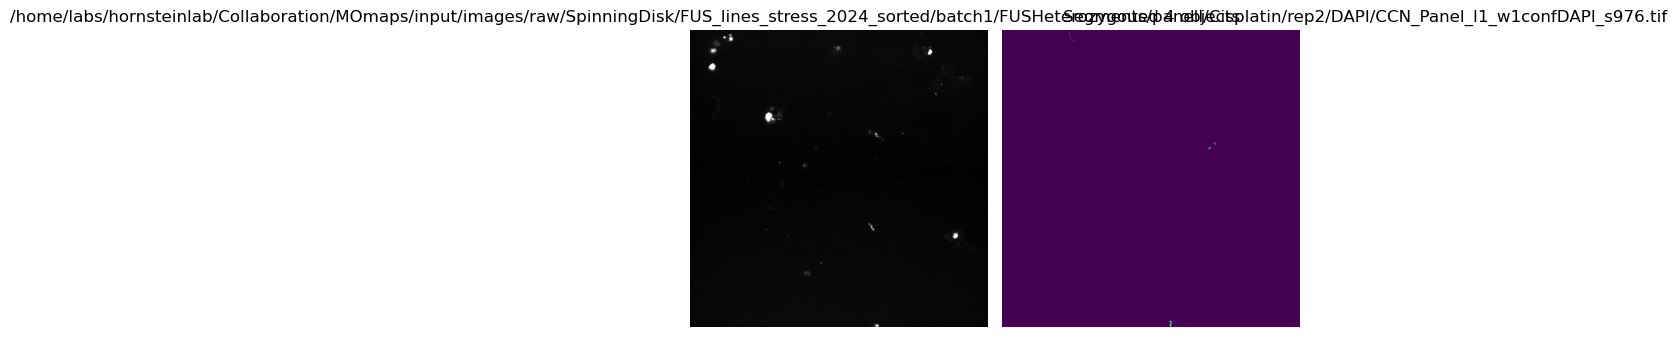

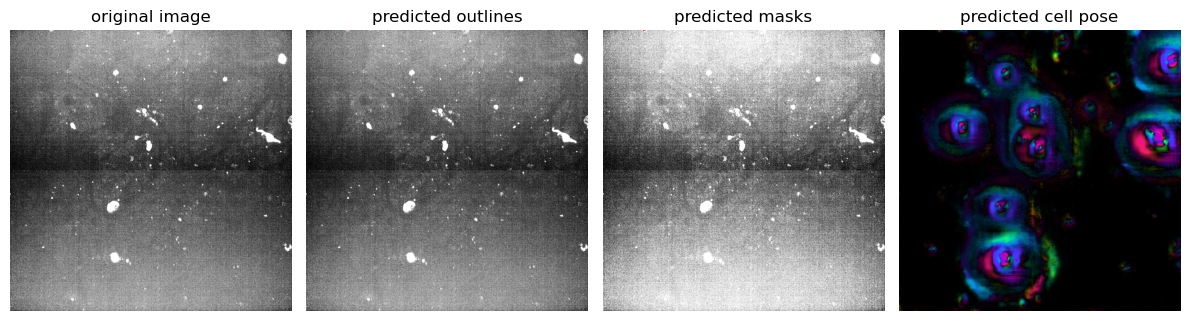

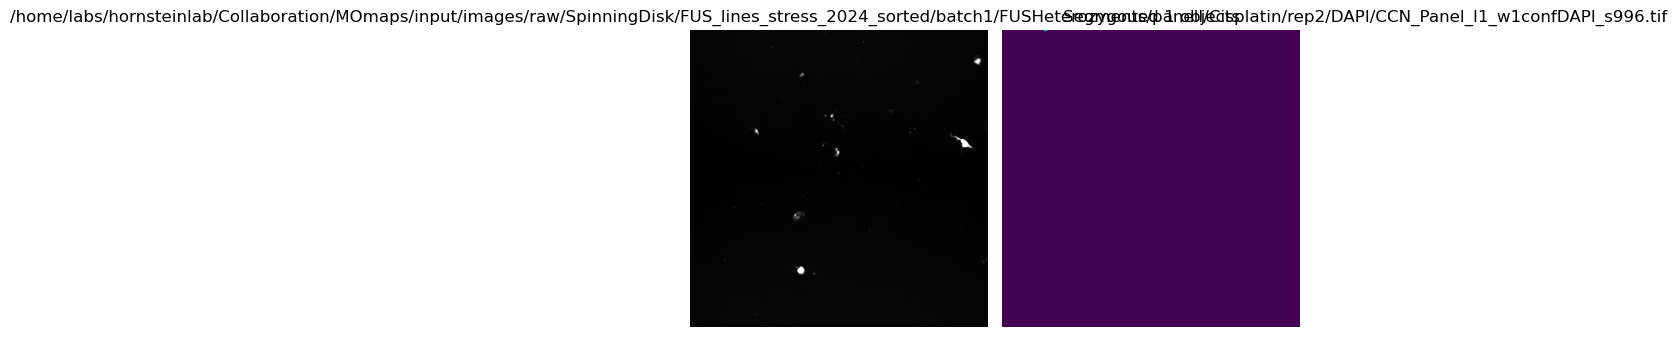

In [97]:
# Apply cellpose on remaining images

for i, image in enumerate(images_processed):
    img = np.stack([image, image], axis=-1)
    kernel = np.array([[-1,-1,-1], [-1,25,-1], [-1,-1,-1]])
    img_for_seg = cv2.filter2D(img, -1, kernel)
    cp_model = models.Cellpose(gpu=True, model_type='nuclei')
    masks, _,_,_ = segment(img=img, channels=[0,0],\
                                    model=cp_model, diameter=60,#60,\
                                    cellprob_threshold=0,\
                                    flow_threshold=0.7, show_plot=True) #channel_axis=-1,
    binary_mask = masks.copy()
    binary_mask[binary_mask>0] = 1
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(image,cmap='gray')#, vmin=0, vmax=1)
    axs[0].axis('off')
    axs[0].set_title(images_paths_processed[i])
    axs[1].imshow(masks)#, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f'Segmented {len(np.unique(masks))-1} objects')
    plt.tight_layout()
    plt.show()


# Processed images

In [15]:
INPUT_DIR_BATCH_PROCESSED = "/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/FUS_lines_stress_2024_sorted/batch1"
figsize=(8,6)
sample_size = 3

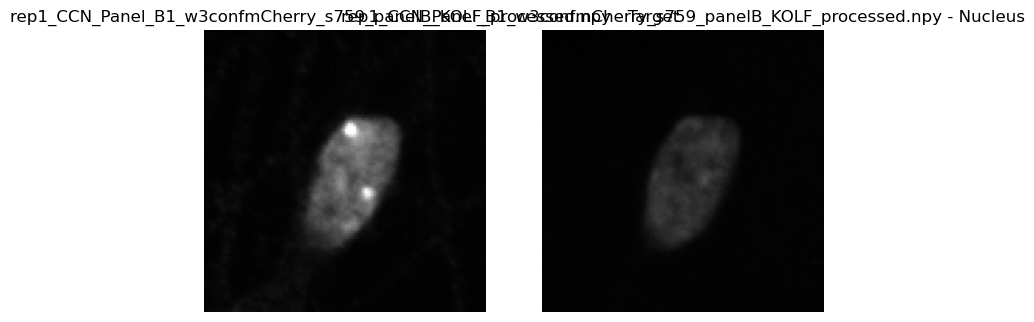

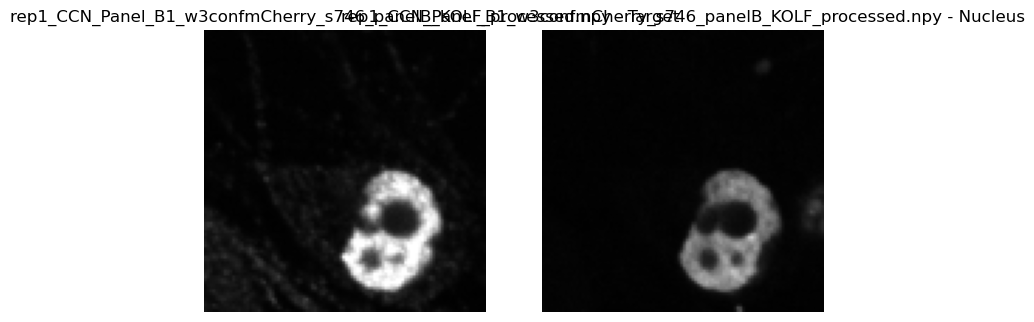

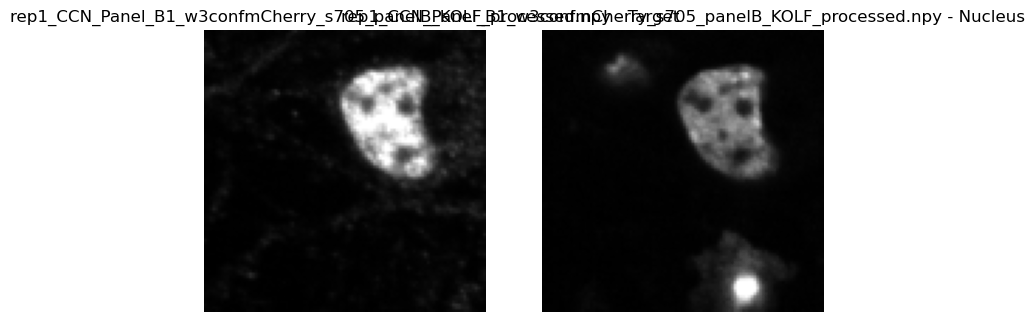

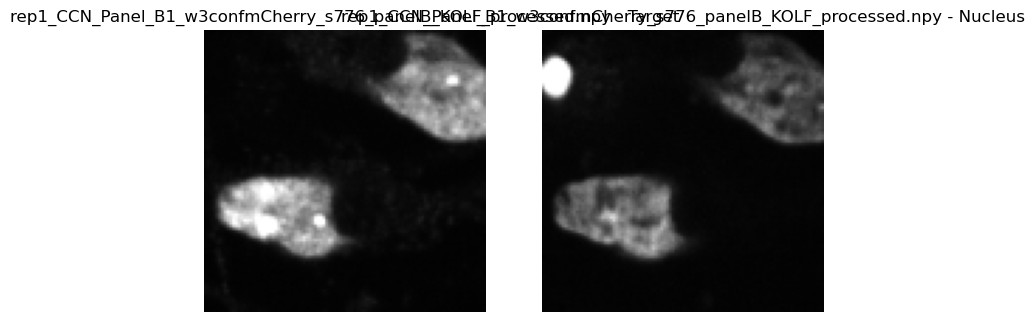

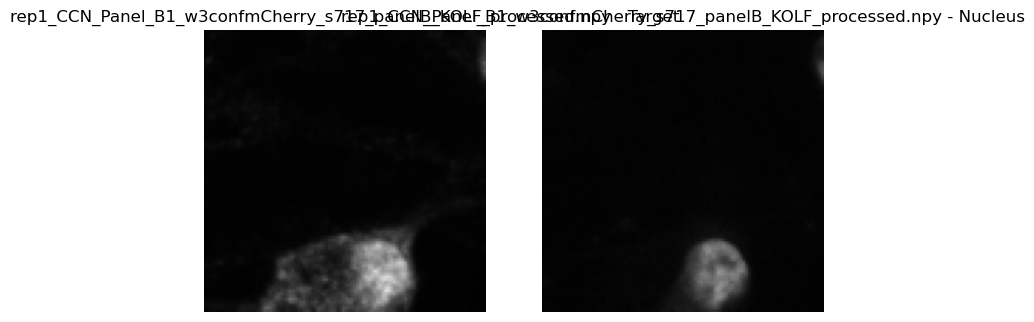

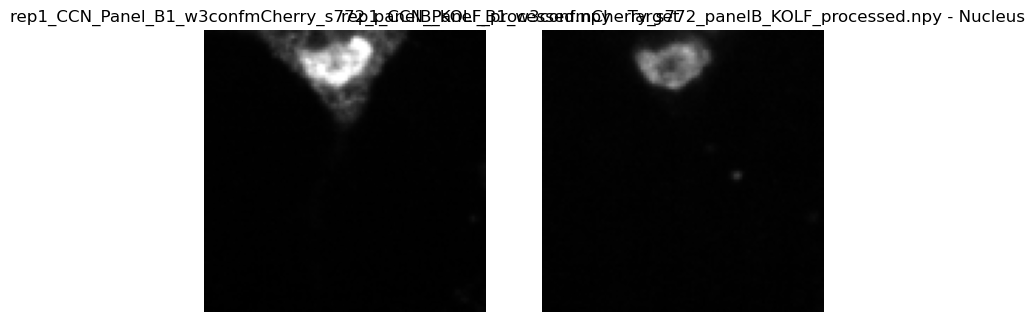

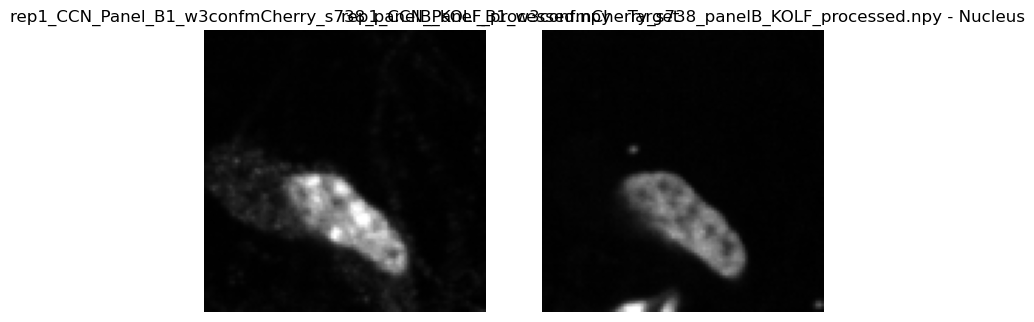

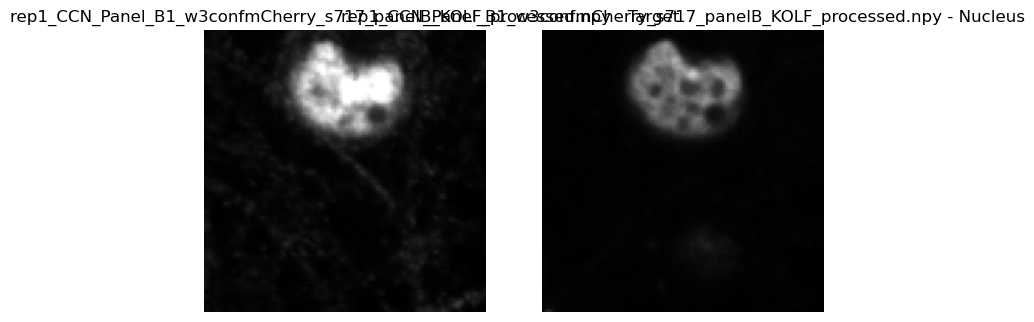

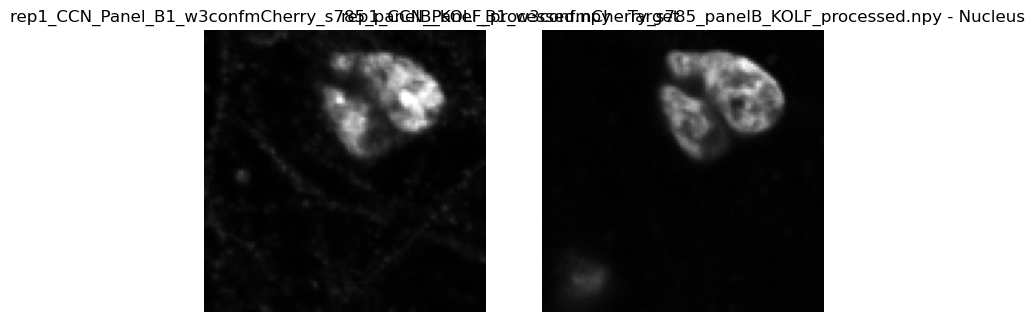

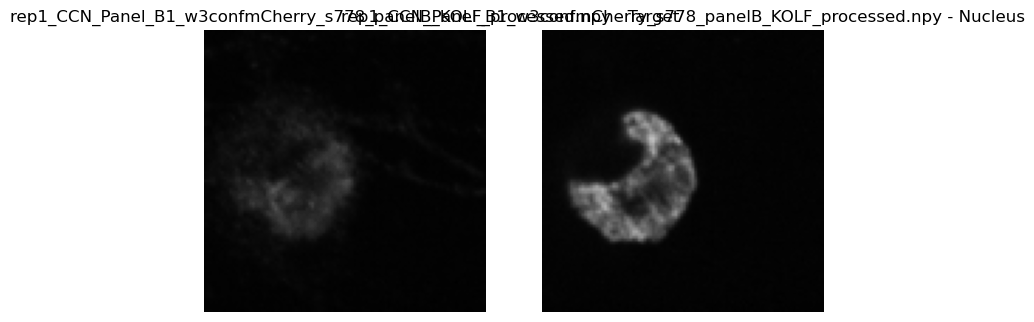

In [33]:
_ = get_processed_images(INPUT_DIR_BATCH_PROCESSED, sample_size=sample_size, marker='NONO', cell_line='KOLF', condition='Cisplatin', reps='rep2', figsize=figsize)

# Reconstructed images

NOTE: Change env to momaps_torch!

In [31]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch

%matplotlib inline

os.environ['MOMAPS_HOME'] = '/home/labs/hornsteinlab/Collaboration/MOmaps'

sys.path.insert(1, os.getenv('MOMAPS_HOME'))
print(f"MOMAPS_HOME: {os.getenv('MOMAPS_HOME')}")

from src.common.lib.image_sampling_utils import sample_images_all_markers_all_lines, sample_raw_images, sample_processed_images
from src.common.lib.eval_preprocessing_steps_utils import get_processed_images
from src.common.lib.model import Model
from src.common.lib.utils import get_if_exists, load_config_file


from src.common.lib import metrics 

MOMAPS_HOME: /home/labs/hornsteinlab/Collaboration/MOmaps


In [51]:
INPUT_DIR_BATCH_PROCESSED = "/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/FUS_lines_stress_2024_sorted/batch1"
figsize=(8,6)
sample_size = 5
marker = 'G3BP1'
cell_line = 'FUSHeterozygous'
condition='BMAA'
reps = 'rep2'

In [52]:
images = get_processed_images(INPUT_DIR_BATCH_PROCESSED, sample_size=sample_size, marker=marker, cell_line=cell_line, condition=condition, reps=reps, figsize=figsize, plot=False)
images.shape

(13, 100, 100, 2)

In [42]:
config_path_model = "./src/models/neuroself/configs/model_config/TLNeuroselfB78NoDSModelConfig"
config_model = load_config_file(config_path_model, 'model')
model = Model(config_model)
model.load_model(num_fc_output_classes=225)

2024-03-03 20:12:08 INFO Creating the model
2024-03-03 20:12:08 INFO early_stop_patience=10, learn_rate=0.0002,                batch_size=4, max_epoch=100
2024-03-03 20:12:08 INFO Init model object (fc output: 225)
/home/labs/hornsteinlab/Collaboration/MOmaps/anaconda3/momaps_torch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(
2024-03-03 20:12:09 INFO Loading model /home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/model_31.pt
2024-03-03 20:12:15 INFO A model has been loaded from /home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/model_31.pt


(13, 2, 100, 100)


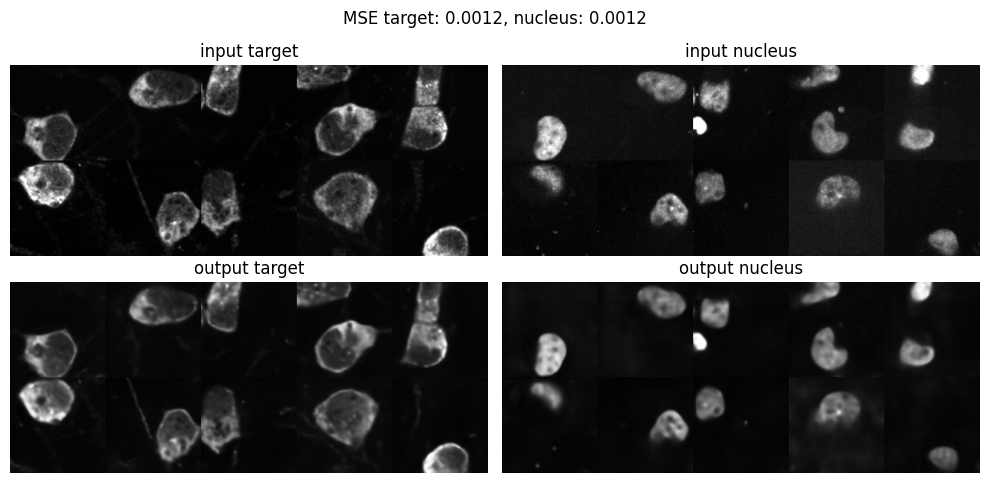

In [53]:
data_ch = ['target', 'nucleus']
img = images.copy()
img = np.transpose(img, (0, 3, 1, 2))
print(img.shape)
torch.cuda.empty_cache()
reconstructed = model.model.infer_reconstruction(img)
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(img[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(reconstructed[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray', vmin=0, vmax=1)
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray', vmin=0, vmax=1)
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)

mses = metrics.calculate_mse(img, reconstructed)
plt.suptitle(f"MSE target: {torch.round(mses['target'], decimals=4)}, nucleus: {torch.round(mses['nucleus'],decimals=4)}")
fig.tight_layout()
plt.show()